# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Installation

In [30]:
# Update the PATH to include the user installation directory. 
# import os
# os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"

# Restart the Kernel before you move on to the next step.

#### Important: Restart the Kernel before you move on to the next step.

In [31]:
# Install requirements
# !python -m pip install -r requirements.txt

## Imports

In [32]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [33]:
# Define transforms
transforms_custom = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

# Create training set and define training dataloader
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms_custom)

validation_size = 5000
train_size = len(trainset) - validation_size
trainset, validationset = torch.utils.data.random_split(trainset, [train_size, validation_size])


# Create test set and define test dataloader
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms_custom)

## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?




-The ToTensor is to convert imgs to numbers.. it also separates imgs to 3 channels and convert them to tensors with intensity values [0-255].

-The Normalize is to normalize each channel making intensity values with zero mean this helps the model to be less sensitive to differences in intenisity changing.

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [34]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

5


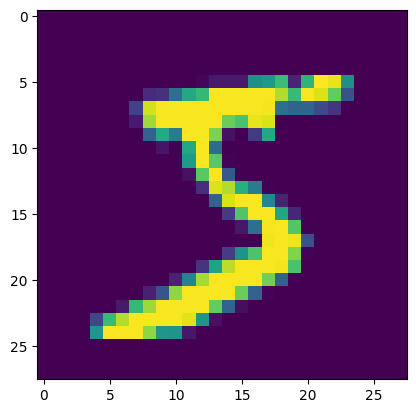

0


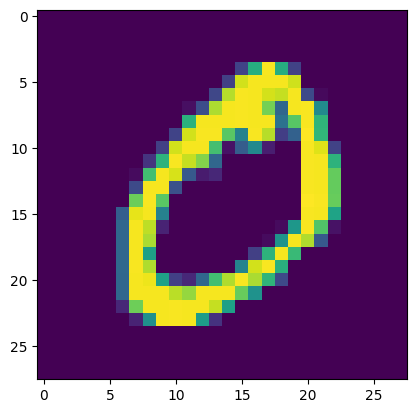

4


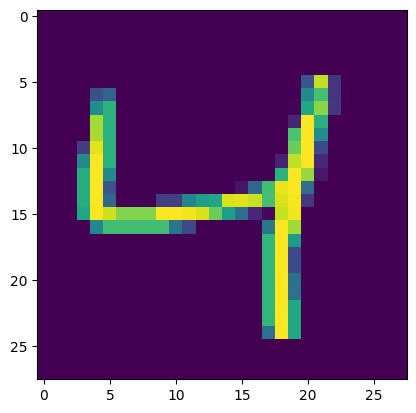

1


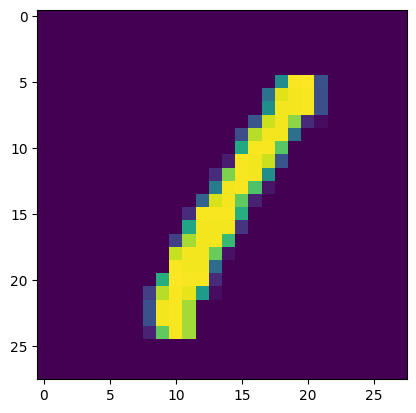

9


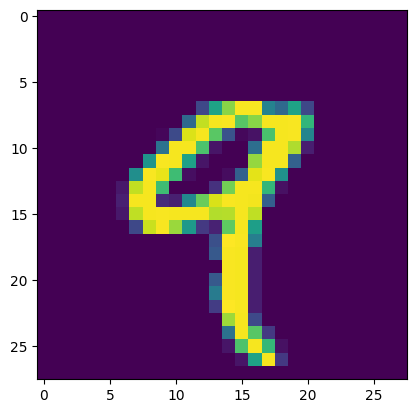

0


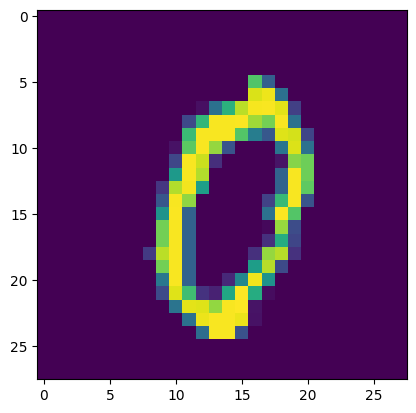

6


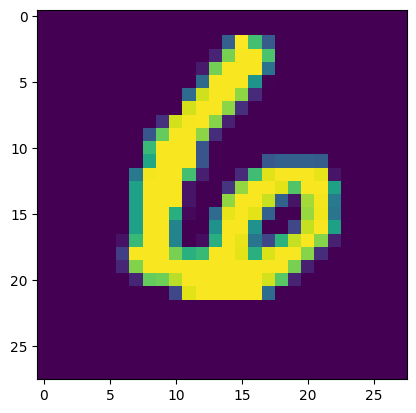

3


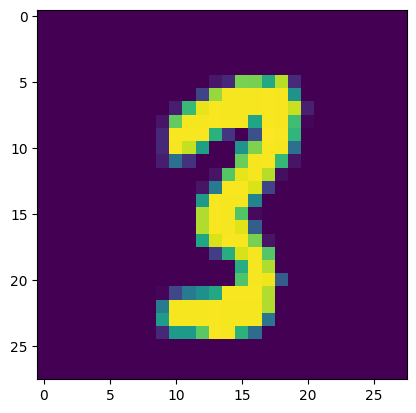

3


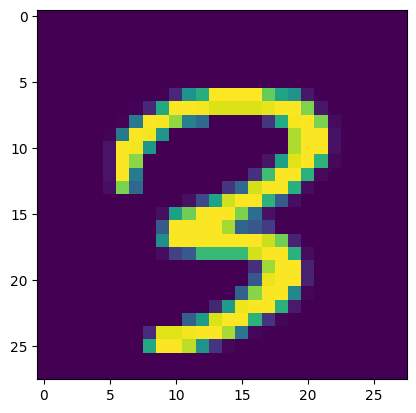

0


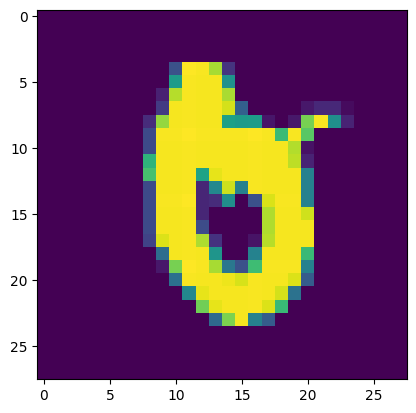

In [35]:
# Explore data
transformsView = transforms.Compose([
    transforms.ToTensor(),
])
viewset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transformsView)
viewloader = torch.utils.data.DataLoader(viewset, batch_size=5,)
show5(viewloader)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,)
show5(trainloader)
validationloader = torch.utils.data.DataLoader(validationset, batch_size=256,)
testloader = torch.utils.data.DataLoader(testset, batch_size=256,)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [36]:
# Define network
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 64)
        self.fc2 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [37]:
# loss function
criterion = nn.CrossEntropyLoss()

# network
net = Net()


# optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [38]:
# training loop
EPOCHS = 20

if torch.cuda.is_available():
    net = net.cuda()
    criterion = criterion.cuda()

train_loss_history = []
val_loss_history = []
for epoch in range(EPOCHS):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, batch in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = batch
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            labels = labels.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimizeY
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
    print(f"Epoch {epoch} loss: {running_loss/len(trainloader)}")
    train_loss_history.append(running_loss/len(trainloader))

    # validation
    correct = 0
    total = 0
    net.eval()
    with torch.no_grad():
        for data in validationloader:
            images, labels = data
            if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.cuda()
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Epoch {epoch} validation accuracy: {correct/total}")
    val_loss_history.append(correct/total)

Epoch 0 loss: 0.5957130422425825
Epoch 0 validation accuracy: 0.9006
Epoch 1 loss: 0.3174205881911655
Epoch 1 validation accuracy: 0.9144
Epoch 2 loss: 0.276034638008406
Epoch 2 validation accuracy: 0.9254
Epoch 3 loss: 0.23960321836693343
Epoch 3 validation accuracy: 0.9348
Epoch 4 loss: 0.2079210726674213
Epoch 4 validation accuracy: 0.9416
Epoch 5 loss: 0.182165818748086
Epoch 5 validation accuracy: 0.9446
Epoch 6 loss: 0.16218152430861496
Epoch 6 validation accuracy: 0.9504
Epoch 7 loss: 0.14677630111921666
Epoch 7 validation accuracy: 0.953
Epoch 8 loss: 0.13437129411586496
Epoch 8 validation accuracy: 0.9552
Epoch 9 loss: 0.12385813306237375
Epoch 9 validation accuracy: 0.956
Epoch 10 loss: 0.11495621528389842
Epoch 10 validation accuracy: 0.9562
Epoch 11 loss: 0.10752692300566408
Epoch 11 validation accuracy: 0.9568
Epoch 12 loss: 0.10099756393668263
Epoch 12 validation accuracy: 0.9582
Epoch 13 loss: 0.0949703264548335
Epoch 13 validation accuracy: 0.9598
Epoch 14 loss: 0.08974

Plot the training loss (and validation loss/accuracy, if recorded).

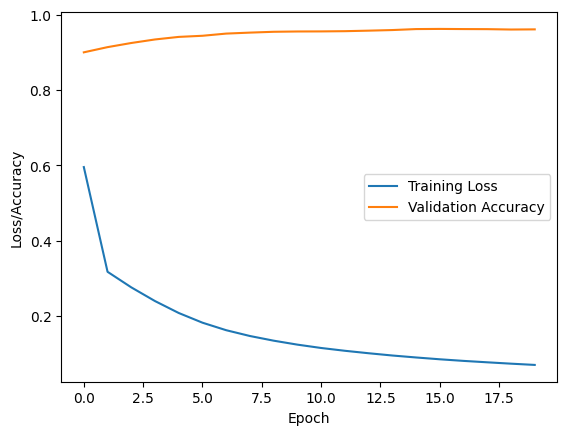

In [39]:
# plot the training loss and validation accuracy/loss
plt.plot(train_loss_history)
plt.plot(val_loss_history)
plt.legend(["Training Loss", "Validation Accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [40]:
# test the network

correct = 0
total = 0
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Final test accuracy: {correct/total}")


Final test accuracy: 0.9672


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

Epoch 0 loss: 0.41699242737404135
Epoch 0 validation accuracy: 0.9704
Epoch 1 loss: 0.0622545214889701
Epoch 1 validation accuracy: 0.9796
Epoch 2 loss: 0.04106504382608935
Epoch 2 validation accuracy: 0.9822
Epoch 3 loss: 0.030818848348720822
Epoch 3 validation accuracy: 0.9832
Epoch 4 loss: 0.023875773859448557
Epoch 4 validation accuracy: 0.983
Epoch 5 loss: 0.018888786231535813
Epoch 5 validation accuracy: 0.9828
Epoch 6 loss: 0.015067469162953108
Epoch 6 validation accuracy: 0.9814
Epoch 7 loss: 0.011344387513574559
Epoch 7 validation accuracy: 0.982
Epoch 8 loss: 0.009262032422432027
Epoch 8 validation accuracy: 0.9858
Epoch 9 loss: 0.00790183438410506
Epoch 9 validation accuracy: 0.9824
Epoch 10 loss: 0.007611293364370371
Epoch 10 validation accuracy: 0.9842
Epoch 11 loss: 0.007628364694916622
Epoch 11 validation accuracy: 0.9844
Epoch 12 loss: 0.006761903495278729
Epoch 12 validation accuracy: 0.9862
Epoch 13 loss: 0.005175647507272769
Epoch 13 validation accuracy: 0.9876
Epoch

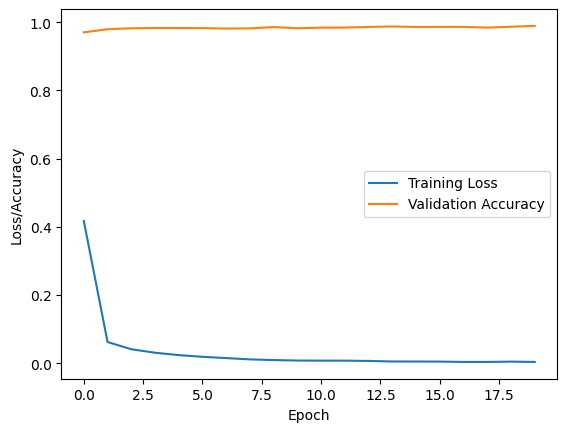

Final test accuracy: 0.9906


In [41]:
# imroving the network
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(1600, 128)  
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 1600)  # Flatten the tensor for the dense layer
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

# loss function
criterion = nn.CrossEntropyLoss()

# network
net = Net()


# optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)

# training loop

if torch.cuda.is_available():
    net = net.cuda()
    criterion = criterion.cuda()

train_loss_history = []
val_loss_history = []

for epoch in range(EPOCHS):  # loop over the dataset multiple times
    
        running_loss = 0.0
        for i, batch in enumerate(trainloader):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = batch
            if torch.cuda.is_available():
                inputs = inputs.cuda()
                labels = labels.cuda()
            # zero the parameter gradients
            optimizer.zero_grad()
    
            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # print statistics
            running_loss += loss.item()
        print(f"Epoch {epoch} loss: {running_loss/len(trainloader)}")
        train_loss_history.append(running_loss/len(trainloader))
    
        # validation
        correct = 0
        total = 0
        net.eval()
        with torch.no_grad():
            for data in validationloader:
                images, labels = data
                if torch.cuda.is_available():
                    images = images.cuda()
                    labels = labels.cuda()
                outputs = net(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        print(f"Epoch {epoch} validation accuracy: {correct/total}")
        val_loss_history.append(correct/total)

# plot the training loss and validation accuracy/loss
plt.plot(train_loss_history)
plt.plot(val_loss_history)
plt.legend(["Training Loss", "Validation Accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.show()

# test the network

correct = 0
total = 0
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Final test accuracy: {correct/total}")




## Saving your model
Using `torch.save`, save your model for future loading.

In [42]:
# saving the model
PATH = './mnist_net.pth'
torch.save(net.state_dict(), PATH)
